In [1]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import csv
import matplotlib.pyplot as plt
from preprocessing import *
from helpers import *
from ALS import *
from plots import plot_raw_data
%load_ext autoreload
%autoreload 2

In [2]:
# import dataset
dataset_file_path = "data_train.csv"
ratings = load_data(dataset_file_path)

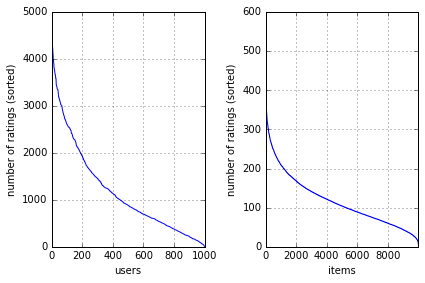

In [3]:
# plot some baselines
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

In [4]:
# set random seed
np.random.seed(888)

In [5]:
# define parameters
init_method_num = 1 # number of matrices initialization method
num_epochs = 1 # number of iterations of ALS
cutoff = True # setting for usage of max_iter_threshold stop condition
max_iter_threshold = 0.00005 # stop condition for ALS algorithm, no visible improvement
num_features = 50 # number of latent features in matrix factorization
lambda_item = 60 # regularization parameter for item features
lambda_user = 10 # regularization parameter for user features
split_ratio = 1.0 # ratio between size of training and test set
test_mode = True
if split_ratio == 1.0:
    test_mode = False

In [6]:
# find the non-zero ratings indices in the training set
nonzero_indices = non_zero_indices(ratings)

In [7]:
# convert sparse matrix representation to dense matrix representation
ratings_dense = scipy.sparse.lil_matrix.todense(ratings)

In [8]:
# preprocessing
initialize_methods = [initialize_matrices_random, initialize_matrices_first_column_mean, initialize_matrices_SVD]
item_features, user_features = None, None

In [9]:
# initialize matrices W and Z
item_features, user_features = initialize_methods[init_method_num](ratings_dense, num_features)

In [10]:
# normalize rows of ratings matrix by substracting mean (bias) rating for each movie
h = np.nanmean(np.where(ratings_dense != 0, ratings_dense, np.nan), axis = 0)
for i, j in nonzero_indices:
    ratings_dense[i, j] -= h[j]

# normalize columns of ratings matrix by substracting mean (bias) rating for each users
v = np.nanmean(np.where(ratings_dense != 0, ratings_dense, np.nan), axis = 1)
for i, j in nonzero_indices:
    ratings_dense[i, j] -= v[i]

In [11]:
# split data into training and test sets
np.random.shuffle(nonzero_indices)

split_point = int(np.floor(len(nonzero_indices) * split_ratio))
train_nonzero_indices = nonzero_indices[:split_point]
test_nonzero_indices = nonzero_indices[split_point:]

train_set = np.zeros(ratings_dense.shape)
test_set = np.zeros(ratings_dense.shape)

for i, j in train_nonzero_indices:
    train_set[i, j] = ratings_dense[i, j]

for i, j in test_nonzero_indices:
    test_set[i, j] = ratings_dense[i, j]

In [12]:
# compute the prediction and errors
prediction, train_rmse, test_rmse, num_iter = compute_ALS(train_set, train_nonzero_indices, test_set, test_nonzero_indices, num_epochs, cutoff, max_iter_threshold, num_features, lambda_item, lambda_user, item_features, user_features, test_mode)

Epoch: 0
RMSE on training set: 0.987939023755
Execution time: 6.745589
**************************************************


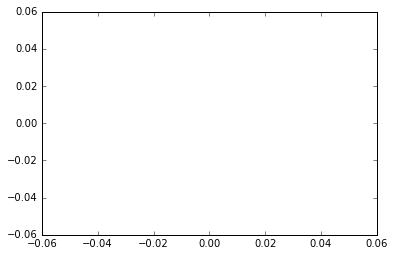

In [13]:
if test_mode == True:
    plt.plot(range(num_iter), train_rmse[:num_iter], range(num_iter), test_rmse[:num_iter])
else:
    plt.plot(range(num_iter), train_rmse[:num_iter])

In [14]:
# denormalize rows of ratings matrix by adding back mean (bias) rating for each movie
H = np.zeros(prediction.shape)
for i in range(prediction.shape[0]):
    H[i, :] = h

# denormalize columns of ratings matrix by adding back mean (bias) rating for each user
V = np.zeros(prediction.shape)
for i in range(prediction.shape[1]):
    V[:, i] = v

prediction = prediction + H + V

In [15]:
if test_mode == False:
    create_csv_submission(prediction)